# Face verification using Siamese Networks

### Goals
- train a network for face similarity using siamese networks
- work data augmentation, generators and hard negative mining
- use the model on your picture


### Dataset

- We will be using Labeled Faces in the Wild (LFW) dataset available openly at http://vis-www.cs.umass.edu/lfw/
- For computing purposes, we'll only restrict ourselves to a subpart of the dataset. You're welcome to train on the whole dataset on GPU, by setting `USE_SUBSET=True` in the following cells,
- We will also load pretrained weights


In [1]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.7
set_session(tf.Session(config=config))

Using TensorFlow backend.


In [2]:
import keras
import os
import keras.backend as K
from keras.models import Model
from keras.layers import Dense, Input, Concatenate, merge, Lambda, Dot
from keras.layers import Conv2D, MaxPool2D, GlobalAveragePooling2D, Flatten, Dropout
import numpy as np
import random
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

## Processing the dataset

The dataset consists of folders corresponding to each identity. The folder name is the name of the person.
We map each class (identity) to an integer id, and build mappings as dictionaries `name_to_classid` and `classid_to_name`

In [3]:
PATH = "lfw/lfw-deepfunneled/"
USE_SUBSET = True

In [4]:
dirs = sorted(os.listdir(PATH))
if USE_SUBSET:
    dirs = dirs[:500]
name_to_classid = {d: i for i, d in enumerate(dirs)}
classid_to_name = {v: k for k, v in name_to_classid.items()}
num_classes = len(name_to_classid)
print("number of classes: ", num_classes)

number of classes:  500


In each directory, there is one or more images corresponding to the identity. We map each image path with an integer id, then build a few dictionaries:
- mappings from imagepath and image id: `path_to_id` and `id_to_path`
- mappings from class id to image ids: `classid_to_ids` and `id_to_classid`

In [5]:
# read all directories
img_paths = {c: [PATH + subfolder + "/" + img
                 for img in sorted(os.listdir(PATH + subfolder))] 
             for subfolder, c in name_to_classid.items()}

# retrieve all images
all_images_path = []
for img_list in img_paths.values():
    all_images_path += img_list

# map to integers
path_to_id = {v: k for k, v in enumerate(all_images_path)}
id_to_path = {v: k for k, v in path_to_id.items()}

In [6]:
# build mappings between images and class
classid_to_ids = {k: [path_to_id[path] for path in v] for k, v in img_paths.items()}
id_to_classid = {v: c for c,imgs in classid_to_ids.items() for v in imgs}
dict(list(id_to_classid.items())[0:13])

{0: 0,
 1: 1,
 2: 2,
 3: 3,
 4: 4,
 5: 5,
 6: 5,
 7: 5,
 8: 5,
 9: 6,
 10: 7,
 11: 7,
 12: 8}

The following histogram shows the number of images per class: there are many classes with only one image. 
These classes are useful as negatives, only as we can't make a positive pair with them.

In [7]:
[(classid_to_name[x], len(classid_to_ids[x]))
 for x in np.argsort([len(v) for k,v in classid_to_ids.items()])[::-1][:10]]

[('Ariel_Sharon', 77),
 ('Arnold_Schwarzenegger', 42),
 ('Alejandro_Toledo', 39),
 ('Andre_Agassi', 36),
 ('Alvaro_Uribe', 35),
 ('Atal_Bihari_Vajpayee', 24),
 ('Amelie_Mauresmo', 21),
 ('Angelina_Jolie', 20),
 ('Abdullah_Gul', 19),
 ('Andy_Roddick', 15)]

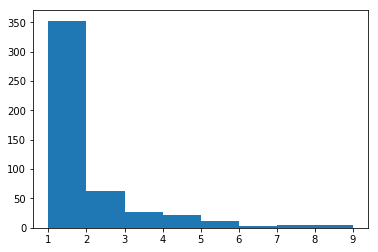

In [9]:
plt.hist([len(v) for k,v in classid_to_ids.items()], bins=range(1,10))
plt.show()

In [10]:
[(classid_to_name[x], len(classid_to_ids[x]))
 for x in np.argsort([len(v) for k,v in classid_to_ids.items()])[::-1][:10]]

[('Ariel_Sharon', 77),
 ('Arnold_Schwarzenegger', 42),
 ('Alejandro_Toledo', 39),
 ('Andre_Agassi', 36),
 ('Alvaro_Uribe', 35),
 ('Atal_Bihari_Vajpayee', 24),
 ('Amelie_Mauresmo', 21),
 ('Angelina_Jolie', 20),
 ('Abdullah_Gul', 19),
 ('Andy_Roddick', 15)]

### Siamese nets

A siamese net takes as input two images $x_1$ and $x_2$ and outputs a single value which corresponds to the similarity between $x_1$ and $x_2$, as follows:

<img src="https://github.com/imadelh/Deep-Learning-Labs/raw/master/Lab-09/images/images/si.png" style="width: 600px;" />



In order to train such a system, one has to build positive and negative pairs for the training. 

In [11]:
# build pairs of positive image ids for a given classid
def build_pos_pairs_for_id(classid, max_num=50):
    imgs = classid_to_ids[classid]
    if len(imgs) == 1:
        return []
    pos_pairs = [(imgs[i], imgs[j])
                 for i in range(len(imgs))
                 for j in range(i + 1, len(imgs))]
    random.shuffle(pos_pairs)
    return pos_pairs[:max_num]


In [14]:
# build pairs of negative image ids for a given classid
def build_neg_pairs_for_id(classid, classes, max_num=20):
    imgs = classid_to_ids[classid]
    neg_classes_ids = random.sample(classes, max_num+1)
    if classid in neg_classes_ids:
        neg_classes_ids.remove(classid)
    neg_pairs = []
    for id2 in range(max_num):
        img1 = imgs[random.randint(0,len(imgs)-1)]
        imgs2 = classid_to_ids[neg_classes_ids[id2]]
        img2 = imgs2[random.randint(0,len(imgs2)-1)]
        neg_pairs += [(img1, img2)]
    return neg_pairs

Let's build positive and a negative pairs for class 5

In [15]:
build_pos_pairs_for_id(5, 20)

[(5, 7), (6, 7), (7, 8), (5, 8), (5, 6), (6, 8)]

In [16]:
build_neg_pairs_for_id(5, list(range(num_classes)), 6)

[(5, 323), (5, 289), (5, 1047), (5, 1144), (6, 390), (5, 707)]

Now that we have a way to compute the pairs, let's open all the possible images. It will expand all the images into RAM memory. There are more than 1000 images, so 100Mo of RAM will be used, which will not cause any issue.

_Note: if you plan on opening more images, you should not open them all at once, and rather build a generator_

In [17]:
from skimage.io import imread
from skimage.transform import resize


def resize100(img):
    return resize(img, (100, 100), preserve_range=True, mode='reflect')[20:80,20:80,:]


def open_all_images(id_to_path):
    all_imgs = []
    for path in id_to_path.values():
        all_imgs += [np.expand_dims(resize100(imread(path)),0)]
    return np.vstack(all_imgs)

In [18]:
all_imgs = open_all_images(id_to_path)
all_imgs.shape

(1155, 60, 60, 3)

In [19]:
str(all_imgs.nbytes / 1e6) + "MB"

'99.792MB'

The following function builds a large number of positives/negatives pairs (train and test)

In [20]:
def build_train_test_data(split=0.8):
    listX1 = []
    listX2 = []
    listY = []
    split = int(num_classes * split)
    
    # train
    for id in range(split):
        pos = build_pos_pairs_for_id(id)
        neg = build_neg_pairs_for_id(id, list(range(split)))
        for pair in pos:
            listX1 += [pair[0]]
            listX2 += [pair[1]]
            listY += [1]
        for pair in neg:
            if sum(listY) > len(listY) / 2:
                listX1 += [pair[0]]
                listX2 += [pair[1]]
                listY += [0]
    perm = np.random.permutation(len(listX1))
    X1_ids_train = np.array(listX1)[perm]
    X2_ids_train = np.array(listX2)[perm]
    Y_ids_train = np.array(listY)[perm]
    
    listX1 = []
    listX2 = []
    listY = []
    
    #test
    for id in range(split, num_classes):
        pos = build_pos_pairs_for_id(id)
        neg = build_neg_pairs_for_id(id, list(range(split, num_classes)))
        for pair in pos:
            listX1 += [pair[0]]
            listX2 += [pair[1]]
            listY += [1]
        for pair in neg:
            if sum(listY) > len(listY) / 2:
                listX1 += [pair[0]]
                listX2 += [pair[1]]
                listY += [0]
    X1_ids_test = np.array(listX1)
    X2_ids_test = np.array(listX2)
    Y_ids_test = np.array(listY)
    return (X1_ids_train, X2_ids_train, Y_ids_train,
            X1_ids_test, X2_ids_test, Y_ids_test)

In [21]:
X1_ids_train, X2_ids_train, train_Y, X1_ids_test, X2_ids_test, test_Y = build_train_test_data()

In [22]:
X1_ids_train.shape, X2_ids_train.shape, train_Y.shape

((2354,), (2354,), (2354,))

In [31]:
np.mean(train_Y)

0.5

In [32]:
X1_ids_test.shape, X2_ids_test.shape, test_Y.shape

((298,), (298,), (298,))

In [33]:
np.mean(test_Y)

0.5

**Data augmentation and generator**

We're building a generator, which will modify images through dataaugmentation on the fly. 
The generator enables
We use iaa library which offers tremendous possibilities for data augmentation


In [33]:
from imgaug import augmenters as iaa

seq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontally flip 50% of the images
    iaa.Affine(rotate = (-15,15))
])


In [34]:
class Generator:

    def __init__(self, X1, X2, Y, batch_size, all_imgs):
        self.cur_train_index=0
        self.batch_size = batch_size
        self.X1 = X1
        self.X2 = X2
        self.Y = Y
        self.imgs = all_imgs
        self.num_samples = Y.shape[0]
        
    def next_train(self):
        while 1:
            self.cur_train_index += self.batch_size
            if self.cur_train_index >= self.num_samples:
                self.cur_train_index=0
            
            imgs1 = self.X1[self.cur_train_index:self.cur_train_index+self.batch_size]
            imgs2 = self.X2[self.cur_train_index:self.cur_train_index+self.batch_size]
    
       # deactivate augmentation
       #     yield ([self.imgs[imgs1], self.imgs[imgs2]],
       #             self.Y[self.cur_train_index:self.cur_train_index+self.batch_size])
        
            yield ([seq.augment_images(self.imgs[imgs1]), 
                    seq.augment_images(self.imgs[imgs2])],
                   self.Y[self.cur_train_index:self.cur_train_index+self.batch_size])

In [35]:
gen = Generator(X1_ids_train, X2_ids_train, train_Y, 32, all_imgs)

In [36]:
[x1, x2], y = next(gen.next_train())

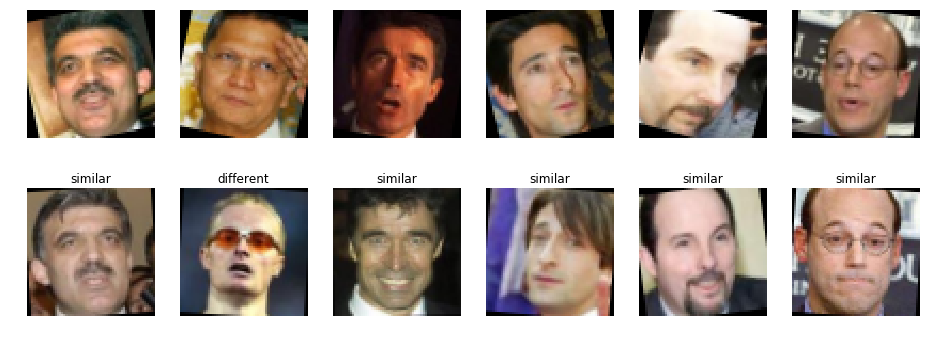

In [37]:
plt.figure(figsize=(16, 6))
for i in range(6):
    plt.subplot(2, 6, i + 1)
    plt.imshow(x1[i] / 255)
    plt.axis('off')
for i in range(6):
    plt.subplot(2, 6, i + 7)
    plt.imshow(x2[i] / 255)
    if y[i]==1.0:
        plt.title("similar")
    else:
        plt.title("different")
    plt.axis('off')
plt.show()

**Exercise**
- Add your own dataaugmentations in the process. You may look at: http://imgaug.readthedocs.io for instance use `iaa.Affine`;
- Be careful not to make the task to difficult, and to add meaningful augmentations;
- Rerun the generator plot above to check whether the image pairs look not too distorted to recognize the identities.

** Test images **

- In addition to our generator, we need test images, unaffected by the augmentation

In [38]:
test_X1 = all_imgs[X1_ids_test]
test_X2 = all_imgs[X2_ids_test]

In [39]:
test_X1.shape, test_X2.shape, test_Y.shape

((298, 60, 60, 3), (298, 60, 60, 3), (298,))

## Simple convolutional model

In [40]:
def contrastive_loss(y_true, y_pred, margin=0.25):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    return K.mean( y_true * K.square(1 - y_pred) +
                  (1 - y_true) * K.square(K.maximum(y_pred - margin, 0)))

In [41]:
def accuracy_sim(y_true, y_pred, threshold=0.5):
    '''Compute classification accuracy with a fixed threshold on similarity.
    '''
    y_thresholded = K.cast(y_pred > threshold, y_true.dtype)
    return K.mean(K.equal(y_true, y_thresholded))

**Exercise**
- Build a convolutional model which transforms the input to a fixed dimension $d = 50$
- You may alternate convolutions and maxpooling and layers,
- Use the relu activation on convolutional layers,
- At the end, `Flatten` the last convolutional output and plug it into a dense layer.
- Feel free to use some `Dropout` prior to the Dense layer.

Use between 32 and 128 channels on convolutional layers. Be careful: large convolutions on high dimensional images can be very slow on CPUs.

Try to run your randomly initialized `shared_conv`  model on a batch of the first 10 images from `all_imgs`. What is the expected shape of the output?

In [42]:
inp = Input((60, 60, 3), dtype='float32')
x = Conv2D(32, 3, activation="relu", padding="same")(inp)
x = Conv2D(32, 3, activation="relu", padding="same")(x)
x = MaxPool2D((2,2))(x) # 15,15
x = Conv2D(64, 3, activation="relu", padding="same")(x)
x = Conv2D(64, 3, activation="relu", padding="same")(x)
x = MaxPool2D((2,2))(x) # 8,8
x = Conv2D(128, 3, activation="relu", padding="same")(x)
x = Conv2D(128, 3, activation="relu", padding="same")(x)
x = MaxPool2D((2,2))(x) 
x = Conv2D(64, 3, activation="relu", padding="same")(x)
x = Conv2D(32, 3, activation="relu", padding="same")(x)
x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(50)(x)

shared_conv = Model(inputs=inp, outputs=x)

In [43]:
all_imgs.shape

(1155, 60, 60, 3)

In [44]:
shared_conv.predict(all_imgs[:10]).shape

(10, 50)

In [45]:
shared_conv.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 60, 60, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 30, 30, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 30, 30, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 64)        0         
__________

**Exercise**

Assemble the siamese model by combining:

- `shared_conv` on both inputs;
- compute the cosine similarity using the [Dot](https://keras.io/layers/merge/#dot) layer with `normalize=True` on the outputs of the two `shared_conv` instance lanes;
- the loss of siamese model is the constrastive loss defined previously;
- use the `accuracy_sim` function defined previously as a metric.
    

In [47]:
i1 = Input((60, 60, 3), dtype='float32')
i2 = Input((60, 60, 3), dtype='float32')

# Apply shared ConvNet

embd1 = shared_conv(i1)
embd2 = shared_conv(i2)

# Compute Cosine 

cosine = keras.layers.dot([embd1,embd2], axes=-1, normalize=True)

model = Model(inputs=[i1, i2], outputs=cosine)

model.summary()

#

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 60, 60, 3)    0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 60, 60, 3)    0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 50)           457714      input_4[0][0]                    
                                                                 input_5[0][0]                    
__________________________________________________________________________________________________
dot_2 (Dot)                     (None, 1)            0           model_1[3][0]                    
          

In [48]:
model.compile(loss=contrastive_loss, optimizer='rmsprop', metrics=[accuracy_sim])


We can now fit the model and checkpoint it to keep the best version. We can expect to get a model with around 0.75 as "accuracy_sim" on the validation set:

In [49]:
from keras.callbacks import ModelCheckpoint
from keras.models import load_model


best_model_fname = "siamese_checkpoint.h5"
best_model_cb = ModelCheckpoint(best_model_fname, monitor='val_accuracy_sim',
                                save_best_only=True, verbose=1)

In [ ]:
model.fit_generator(generator=gen.next_train(), 
                    steps_per_epoch=train_Y.shape[0] // 32, 
                    epochs=3,
                    validation_data=([test_X1, test_X2], test_Y),
                    callbacks=[best_model_cb], verbose=2)

In [ ]:
model.load_weights("siamese_checkpoint.h5")

In [ ]:
# You may load a pre-trained model if you have the exact solution architecture. 
# This model is a start, but far from perfect !
# model.load_weights("siamese_pretrained.h5")

**Exercise**

Finding the most similar images

- Run the shared_conv model on all images;
- (Optional) add Charles and Olivier's faces from the `test_images` folder to the test set;
- build a `most_sim` function which returns the most similar vectors to a given vector.

In [ ]:
# TODO

emb = None

def most_sim(x, emb, topn=3):
    return None

In [91]:
# Optional: add some test images
more_img_paths = {
    'olivier': [os.path.join('test_images/olivier', img)
                for img in sorted(os.listdir('test_images/olivier'))],
    'charles': [os.path.join('test_images/charles', img)
                for img in sorted(os.listdir('test_images/charles'))],
}
img_paths.update(more_img_paths)
all_images_path = []
for img_list in img_paths.values():
    all_images_path += img_list
path_to_id = {v: k for k, v in enumerate(all_images_path)}
id_to_path = {v: k for k, v in path_to_id.items()}
all_imgs = open_all_images(id_to_path)

# Actually compute the similarities
emb = shared_conv.predict(all_imgs)
emb = emb / np.linalg.norm(emb, axis=-1, keepdims=True)

def most_sim(x, emb, topn=4):
    sims = np.dot(emb, x)
    ids = np.argsort(sims)[::-1]
    return [(id, sims[id]) for id in ids[:topn]]

** Most similar faces **

The following enables to display an image alongside with most similar images:

- The results are weak, first because of the size of the dataset
- Also, the network can be greatly improved

In [92]:
def display(img):
    img = img.astype('uint8')
    plt.imshow(img)
    plt.axis('off')
    plt.show()

query: Amelia_Vega 461
nearest matches
Amelia_Vega 461 1.0


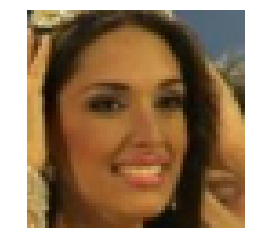

Alejandro_Toledo 255 0.999168


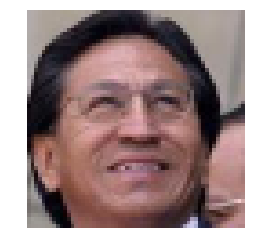

Alexander_Downer 313 0.999052


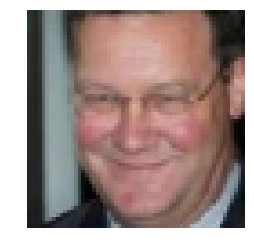

Alicia_Keys 368 0.998991


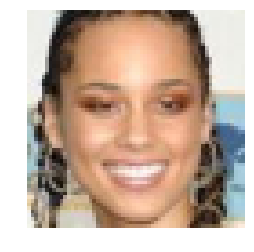

In [97]:
interesting_classes = list(filter(lambda x: len(x[1]) > 4, classid_to_ids.items()))
class_id = random.choice(interesting_classes)[0]

query_id = random.choice(classid_to_ids[class_id])
print("query:", classid_to_name[class_id], query_id)
# display(all_imgs[query_id])

print("nearest matches")
for result_id, sim in most_sim(emb[query_id], emb):
    class_name = classid_to_name.get(id_to_classid.get(result_id))
    print(class_name, result_id, sim)    
    display(all_imgs[result_id])

Note that this model is still underfitting, even when running queries against the training set. Even if the results are not correct, the mistakes often seem to "make sense" though.

Running a model to convergence on higher resolution images, possibly with a deeper and wider convolutional network might yield better results. In the next notebook we will try with a better loss and with hard negative mining.

**Playing with the camera**
- The following code enables you to find the most similar faces to yours
- What do you observe?
- Try to think of reasons why it doesn't work very well, and how you could improve it.

In [ ]:
import cv2

def camera_grab(camera_id=0, fallback_filename=None):
    camera = cv2.VideoCapture(camera_id)
    try:
        # take 10 consecutive snapshots to let the camera automatically tune
        # itself and hope that the contrast and lightning of the last snapshot
        # is good enough.
        for i in range(10):
            snapshot_ok, image = camera.read()
        if snapshot_ok:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        else:
            print("WARNING: could not access camera")
            if fallback_filename:
                image = imread(fallback_filename)
    finally:
        camera.release()
    return image

In [ ]:
image = camera_grab(camera_id=0,
                    fallback_filename='test_images/olivier/img_olivier_0.jpeg')
x = resize100(image)
out = shared_conv.predict(np.reshape(x, (1, 60, 60, 3)))
print("query image:")
display(x)
for id, sim in most_sim(out[0], emb, topn=10):
    class_name = classid_to_name.get(id_to_classid.get(id))
    print(class_name, id, sim)
    display(all_imgs[id])